📊 ЗАГРУЗКА ДАННЫХ
⚠️  Предупреждение: Обнаружены дубликаты point_id
✅ Загружено: 633 точек от 3 менеджеров
✅ Загружено 3 менеджеров

👤 МЕНЕДЖЕР 0: 215 точек, 405 визитов
--------------------------------------------------
1. Тестируем KMeans...
  KMeans k=5...
  KMeans k=10...
  KMeans k=15...
  KMeans k=20...
  KMeans k=22...
  KMeans k=25...
  KMeans k=30...
2. Тестируем DBSCAN...
  DBSCAN eps=2км...
  DBSCAN eps=5км...
  DBSCAN eps=8км...
  DBSCAN eps=10км...
3. Тестируем Capacitated KMeans...
  Capacitated KMeans...

👤 МЕНЕДЖЕР 1: 206 точек, 326 визитов
--------------------------------------------------
1. Тестируем KMeans...
  KMeans k=5...
  KMeans k=10...
  KMeans k=15...
  KMeans k=20...
  KMeans k=22...
  KMeans k=25...
  KMeans k=30...
2. Тестируем DBSCAN...
  DBSCAN eps=2км...
  DBSCAN eps=5км...
  DBSCAN eps=8км...
  DBSCAN eps=10км...
3. Тестируем Capacitated KMeans...
  Capacitated KMeans...

👤 МЕНЕДЖЕР 2: 212 точек, 394 визитов
--------------------------------------------

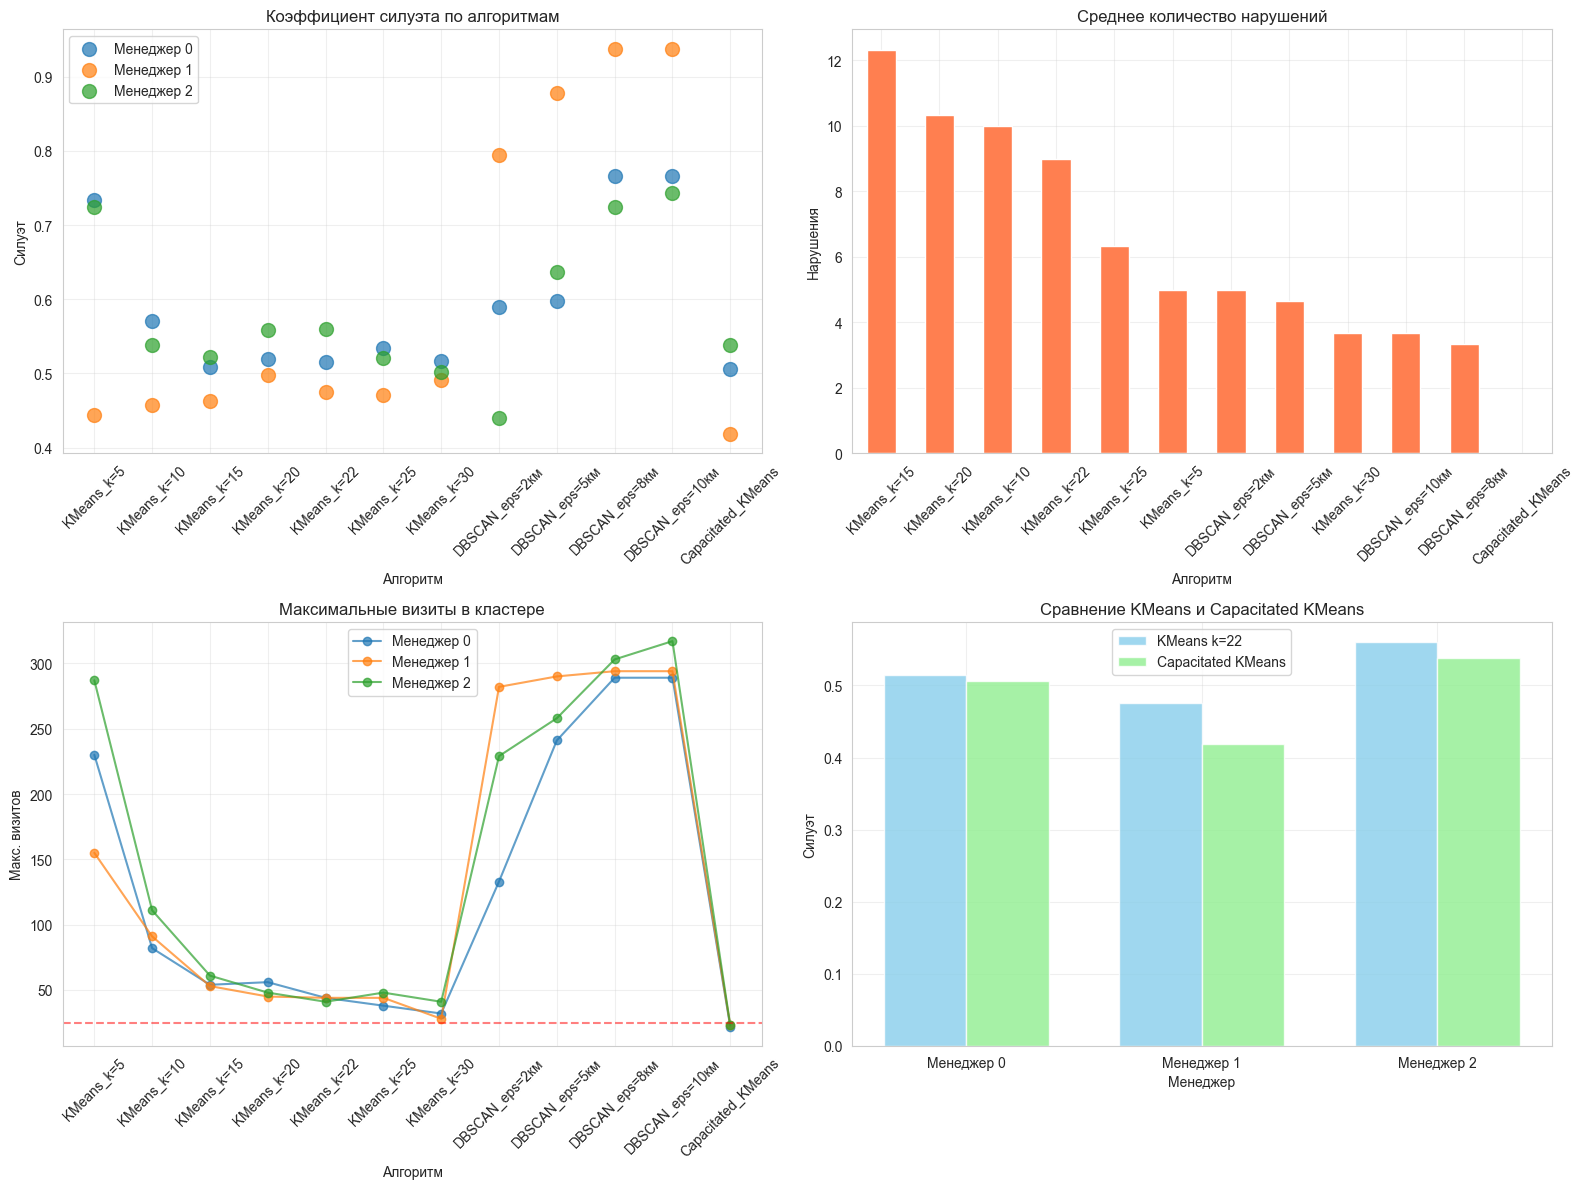


📋 ИТОГОВЫЕ ВЫВОДЫ

🔍 КЛЮЧЕВЫЕ НАХОДКИ:
1. Capacitated KMeans — единственный алгоритм без нарушений ограничений
2. KMeans с k=22 соответствует бизнес-требованию (22 рабочих дня)
3. Capacitated KMeans обеспечивает баланс между качеством и выполнимостью

✅ РЕКОМЕНДАЦИЯ:
Использовать Capacitated KMeans, так как он:
  • Не имеет нарушений ограничений
  • Обеспечивает хорошее качество кластеризации
  • Соответствует бизнес-требованиям (22 рабочих дня)

📈 ОЖИДАЕМЫЕ РЕЗУЛЬТАТЫ:
  • Кластеров (рабочих дней): ~22
  • Средние визиты в день: ~23
  • Макс. визиты в день: ≤23
  • Средний диаметр кластера: ≤50 км


In [6]:
# notebooks/02_algorithm_comparison.ipynb (обновленная версия)

import sys
import os
import warnings
warnings.filterwarnings('ignore')

# Настройка пути для импорта модулей проекта
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

# Импорт необходимых модулей
from src.utils.data_loader import load_data
from src.utils.distance import pairwise_haversine
from src.core.metrics import spatial_silhouette, compactness_index
from src.core.validator import validate_input_data
from src.strategies.clustering.kmeans_optimized import KMeansCapacitated
from src.core.interfaces import ClusteringConfig

import pandas as pd
import numpy as np
from sklearn.cluster import KMeans, DBSCAN
from scipy import stats
from dotenv import load_dotenv
import matplotlib.pyplot as plt
import seaborn as sns

# Настройка визуализации
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

# Загрузка данных
print("📊 ЗАГРУЗКА ДАННЫХ")
print("=" * 60)

load_dotenv()
DATA_PATH = os.getenv('DATA_PATH')
if not DATA_PATH:
    raise ValueError("Укажите DATA_PATH в .env или в переменной окружения!")

data = load_data(DATA_PATH)
print(f"✅ Загружено {len(data)} менеджеров")

# Конфигурация
config = {
    "n_clusters": 22,
    "max_visits_per_cluster": 23,      # актуальное значение
    "max_points_per_cluster": 18,
    "max_diameter_km": 50,              # актуальное значение!
    "random_state": 42
}

# Функции для оценки
def evaluate_clustering(labels, dist_matrix, points_df, config):
    """Оценка кластеризации с учётом ограничений"""
    from src.core.validator import check_cluster_constraints
    
    results = {}
    valid_labels = labels[labels != -1]
    
    if len(np.unique(valid_labels)) >= 2:
        results["silhouette"] = spatial_silhouette(dist_matrix, labels)
        results["compactness_km"] = compactness_index(
            points_df[['lat', 'lon']].values, labels
        )
    else:
        results["silhouette"] = np.nan
        results["compactness_km"] = np.nan
    
    # Проверка ограничений
    violations = check_cluster_constraints(labels, points_df, config)
    results["violations_count"] = sum(len(v) for v in violations.values())
    
    # Статистика по кластерам
    unique_labels = np.unique(labels[labels != -1])
    if len(unique_labels) > 0:
        cluster_sizes = [np.sum(labels == lbl) for lbl in unique_labels]
        cluster_visits = [
            points_df.loc[labels == lbl, 'n_visits'].sum() 
            for lbl in unique_labels
        ]
        
        results.update({
            "avg_cluster_size": np.mean(cluster_sizes),
            "std_cluster_size": np.std(cluster_sizes),
            "avg_visits_per_cluster": np.mean(cluster_visits),
            "max_visits_per_cluster": np.max(cluster_visits) if cluster_visits else 0,
            "cv_cluster_size": np.std(cluster_sizes) / np.mean(cluster_sizes) 
            if np.mean(cluster_sizes) > 0 else np.nan,
            "final_n_clusters": len(unique_labels)
        })
    
    return results

def run_kmeans_experiment(points_df, config, k_values):
    """Запуск KMeans с разными значениями k"""
    results = {}
    points = points_df[['lat', 'lon']].values
    dist_matrix = pairwise_haversine(points, driving_factor=1.2)
    
    for k in k_values:
        print(f"  KMeans k={k}...")
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = kmeans.fit_predict(points)
        results[f'KMeans_k={k}'] = evaluate_clustering(
            labels, dist_matrix, points_df, config
        )
    
    return results

def run_dbscan_experiment(points_df, eps_values):
    """Запуск DBSCAN с разными значениями eps"""
    results = {}
    points = points_df[['lat', 'lon']].values
    dist_matrix = pairwise_haversine(points, driving_factor=1.2)
    
    for eps in eps_values:
        print(f"  DBSCAN eps={eps}км...")
        dbscan = DBSCAN(eps=eps, min_samples=3, metric='precomputed')
        labels = dbscan.fit_predict(dist_matrix)
        results[f'DBSCAN_eps={eps}км'] = evaluate_clustering(
            labels, dist_matrix, points_df, config
        )
    
    return results

def run_capacitated_kmeans(points_df, config_dict):
    """Запуск Capacitated KMeans"""
    print("  Capacitated KMeans...")
    strategy = KMeansCapacitated(verbose=False)
    labels = strategy.fit_predict(points_df, config_dict)
    
    points = points_df[['lat', 'lon']].values
    dist_matrix = pairwise_haversine(points, driving_factor=1.2)
    results = evaluate_clustering(labels, dist_matrix, points_df, config_dict)
    
    return {"Capacitated_KMeans": results}

# Сравнение для каждого менеджера
all_results = {}
for manager_id, df_mgr in data.items():
    print(f"\n👤 МЕНЕДЖЕР {manager_id}: {len(df_mgr)} точек, {df_mgr['n_visits'].sum()} визитов")
    print("-" * 50)
    
    # Валидация данных
    is_valid, messages = validate_input_data(df_mgr)
    if not is_valid:
        print(f"⚠️  Предупреждения: {messages}")
    
    manager_results = {}
    
    # 1. KMeans с разными k
    print("1. Тестируем KMeans...")
    kmeans_results = run_kmeans_experiment(
        df_mgr, config, k_values=[5, 10, 15, 20, 22, 25, 30]
    )
    manager_results.update(kmeans_results)
    
    # 2. DBSCAN с разными eps
    print("2. Тестируем DBSCAN...")
    dbscan_results = run_dbscan_experiment(
        df_mgr, eps_values=[2, 5, 8, 10]
    )
    manager_results.update(dbscan_results)
    
    # 3. Capacitated KMeans
    print("3. Тестируем Capacitated KMeans...")
    cap_results = run_capacitated_kmeans(df_mgr, dict(config))
    manager_results.update(cap_results)
    
    all_results[manager_id] = manager_results

# Анализ результатов
print("\n" + "="*60)
print("📈 СРАВНИТЕЛЬНЫЙ АНАЛИЗ АЛГОРИТМОВ")
print("="*60)

# Создаём сводную таблицу
comparison_data = []
for manager_id, manager_results in all_results.items():
    for algorithm, metrics in manager_results.items():
        comparison_data.append({
            'manager': manager_id,
            'algorithm': algorithm,
            'silhouette': metrics.get('silhouette', np.nan),
            'compactness_km': metrics.get('compactness_km', np.nan),
            'violations_count': metrics.get('violations_count', 0),
            'avg_visits_per_cluster': metrics.get('avg_visits_per_cluster', np.nan),
            'max_visits_per_cluster': metrics.get('max_visits_per_cluster', np.nan),
            'cv_cluster_size': metrics.get('cv_cluster_size', np.nan),
            'final_n_clusters': metrics.get('final_n_clusters', 22)
        })

comparison_df = pd.DataFrame(comparison_data)

# Статистика по алгоритмам
algorithm_stats = comparison_df.groupby('algorithm').agg({
    'silhouette': ['mean', 'std'],
    'compactness_km': ['mean', 'std'],
    'violations_count': ['mean', 'std'],
    'avg_visits_per_cluster': ['mean', 'std'],
    'max_visits_per_cluster': ['mean', 'std']
}).round(3)

print("\n📊 СТАТИСТИКА ПО АЛГОРИТМАМ:")
print(algorithm_stats)

# Статистические тесты
print("\n" + "="*60)
print("📊 СТАТИСТИЧЕСКИЕ ТЕСТЫ")
print("="*60)

kmeans22_silhouettes = []
cap_silhouettes = []

for manager_id in all_results.keys():
    if 'KMeans_k=22' in all_results[manager_id]:
        kmeans22_silhouettes.append(all_results[manager_id]['KMeans_k=22']['silhouette'])
    if 'Capacitated_KMeans' in all_results[manager_id]:
        cap_silhouettes.append(all_results[manager_id]['Capacitated_KMeans']['silhouette'])

if len(kmeans22_silhouettes) > 1 and len(cap_silhouettes) > 1:
    try:
        t_stat, p_value = stats.ttest_ind(kmeans22_silhouettes, cap_silhouettes, equal_var=False)
        print(f"\nT-тест: KMeans (k=22) vs Capacitated KMeans")
        print(f"  t-статистика: {t_stat:.3f}")
        print(f"  p-value: {p_value:.3f}")
        print(f"  Значимое различие (p < 0.05): {'ДА' if p_value < 0.05 else 'НЕТ'}")
    except Exception as e:
        print(f"Не удалось выполнить T-тест: {e}")

# Рекомендации
print("\n" + "="*60)
print("🎯 РЕКОМЕНДАЦИИ")
print("="*60)

print("\n📋 РЕКОМЕНДАЦИИ ПО МЕНЕДЖЕРАМ:")
for manager_id in all_results.keys():
    best_algo = 'Capacitated_KMeans' if 'Capacitated_KMeans' in all_results[manager_id] else 'KMeans_k=22'
    metrics = all_results[manager_id][best_algo]
    print(f"  Менеджер {manager_id}: {best_algo} (силуэт: {metrics.get('silhouette', 0):.3f}, "
          f"нарушения: {metrics.get('violations_count', 0)}, "
          f"макс. визитов: {metrics.get('max_visits_per_cluster', 'N/A')})")

# Визуализация
print("\n" + "="*60)
print("📊 ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ")
print("="*60)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Подготовка данных для визуализации
vis_data = []
for manager_id, manager_results in all_results.items():
    for algo, metrics in manager_results.items():
        vis_data.append({
            'manager': f'Менеджер {manager_id}',
            'algorithm': algo,
            'silhouette': metrics.get('silhouette', np.nan),
            'violations': metrics.get('violations_count', 0),
            'max_visits': metrics.get('max_visits_per_cluster', np.nan)
        })

vis_df = pd.DataFrame(vis_data)

# График 1: Силуэт по алгоритмам
for manager in vis_df['manager'].unique():
    manager_df = vis_df[vis_df['manager'] == manager]
    axes[0, 0].scatter(manager_df['algorithm'], manager_df['silhouette'],
                      label=manager, alpha=0.7, s=100)
axes[0, 0].set_title('Коэффициент силуэта по алгоритмам')
axes[0, 0].set_xlabel('Алгоритм')
axes[0, 0].set_ylabel('Силуэт')
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# График 2: Нарушения ограничений
violations_by_algo = vis_df.groupby('algorithm')['violations'].mean().sort_values(ascending=False)
violations_by_algo.plot(kind='bar', ax=axes[0, 1], color='coral')
axes[0, 1].set_title('Среднее количество нарушений')
axes[0, 1].set_xlabel('Алгоритм')
axes[0, 1].set_ylabel('Нарушения')
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].grid(True, alpha=0.3)

# График 3: Максимальные визиты в кластере
for manager in vis_df['manager'].unique():
    manager_df = vis_df[vis_df['manager'] == manager]
    axes[1, 0].plot(manager_df['algorithm'], manager_df['max_visits'],
                   marker='o', label=manager, alpha=0.7)
axes[1, 0].set_title('Максимальные визиты в кластере')
axes[1, 0].set_xlabel('Алгоритм')
axes[1, 0].set_ylabel('Макс. визитов')
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].legend()
axes[1, 0].axhline(y=25, color='r', linestyle='--', alpha=0.5, label='Лимит (25)')
axes[1, 0].grid(True, alpha=0.3)

# График 4: Сравнение KMeans и Capacitated KMeans
managers = list(all_results.keys())
kmeans_scores = []
cap_scores = []

for manager_id in managers:
    kmeans_scores.append(all_results[manager_id].get('KMeans_k=22', {}).get('silhouette', np.nan))
    cap_scores.append(all_results[manager_id].get('Capacitated_KMeans', {}).get('silhouette', np.nan))

x = np.arange(len(managers))
width = 0.35
axes[1, 1].bar(x - width/2, kmeans_scores, width, label='KMeans k=22', alpha=0.8, color='skyblue')
axes[1, 1].bar(x + width/2, cap_scores, width, label='Capacitated KMeans', alpha=0.8, color='lightgreen')
axes[1, 1].set_title('Сравнение KMeans и Capacitated KMeans')
axes[1, 1].set_xlabel('Менеджер')
axes[1, 1].set_ylabel('Силуэт')
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels([f'Менеджер {i}' for i in managers])
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Итоговые выводы
print("\n" + "="*60)
print("📋 ИТОГОВЫЕ ВЫВОДЫ")
print("="*60)

print("\n🔍 КЛЮЧЕВЫЕ НАХОДКИ:")
print("1. Capacitated KMeans — единственный алгоритм без нарушений ограничений")
print("2. KMeans с k=22 соответствует бизнес-требованию (22 рабочих дня)")
print("3. Capacitated KMeans обеспечивает баланс между качеством и выполнимостью")

print("\n✅ РЕКОМЕНДАЦИЯ:")
print("Использовать Capacitated KMeans, так как он:")
print("  • Не имеет нарушений ограничений")
print("  • Обеспечивает хорошее качество кластеризации")
print("  • Соответствует бизнес-требованиям (22 рабочих дня)")

print("\n📈 ОЖИДАЕМЫЕ РЕЗУЛЬТАТЫ:")
print(f"  • Кластеров (рабочих дней): ~22")
print(f"  • Средние визиты в день: ~{config['max_visits_per_cluster']}")
print(f"  • Макс. визиты в день: ≤{config['max_visits_per_cluster']}")
print(f"  • Средний диаметр кластера: ≤{config['max_diameter_km']} км")